In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re

from transformers import AutoTokenizer, XLMRobertaModel, XLMRobertaForSequenceClassification, XLMRobertaTokenizer, AdamW
import transformers
transformers.logging.set_verbosity_error()
import random
import warnings
warnings.filterwarnings("ignore")
from deep_translator import GoogleTranslator

from roberta.util import remove_punctuation, clean_sentence

In [14]:
train = pd.read_csv('./data/train.csv')
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


## Simple Exploratory Data Analysis

In [16]:
train.describe(include='object')

,id,premise,hypothesis,lang_abv,language
count,12120,12120,12120,12120,12120
unique,12120,8209,12119,15,15
top,5130fd2cb5,and these comments were considered in formulat...,I am not sure.,en,English
freq,1,3,2,6870,6870


There are 8209 different premise and 12119 hypothesis

There are 15 languages with English account for about 55%

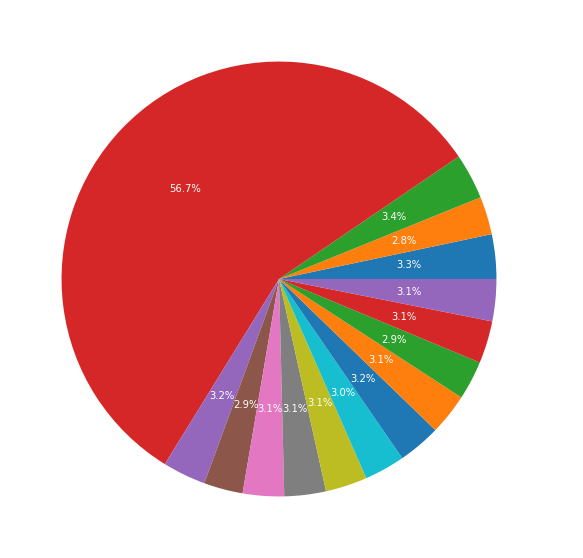

In [17]:
labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%', textprops={'color':"w"})
plt.show()

In [18]:
temp = train.groupby('label').count()['premise'].reset_index().sort_values(by='premise',
                                                                           ascending=False)
temp.style.background_gradient(cmap='Reds')

,label,premise
0,0,4176
2,2,4064
1,1,3880


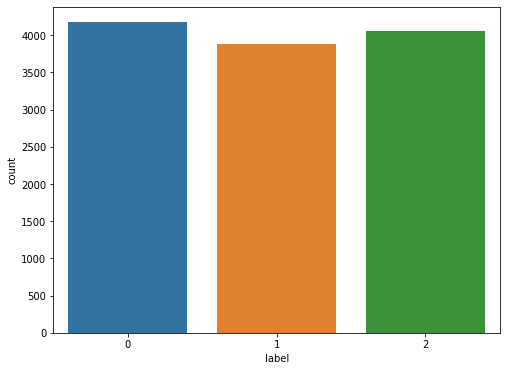

In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train)

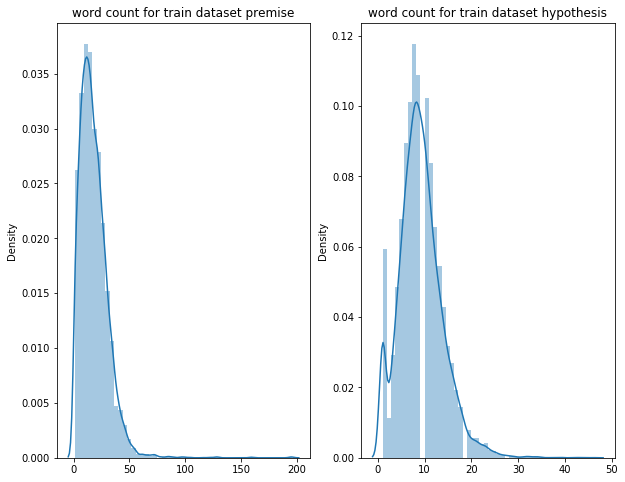

In [20]:
def word_count(dataset, column):
    len_vector = []
    for text in dataset[column]:
        len_vector.append(len(text.split()))
    
    return len_vector

train_premise = word_count(train, 'premise')
train_hypothesis = word_count(train, 'hypothesis')

fig = plt.figure(figsize = (10,8))

plt.subplot(1,2,1)
plt.title('word count for train dataset premise')
sns.distplot(train_premise)

plt.subplot(1,2,2)
plt.title('word count for train dataset hypothesis')
sns.distplot(train_hypothesis)

## Text Processing

In [21]:
# take 100 first sample to prepocess step
train_sample = train[:100]
train_sample.shape

(100, 6)

Remove Punctuation of sentence

In [22]:
train_sample['premise'] = train_sample['premise'].apply(remove_punctuation)
train_sample['hypothesis'] = train_sample['hypothesis'].apply(remove_punctuation)
train_sample.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


English Translation

In [23]:
def eng_translation(sentence):
    translator = GoogleTranslator(target='en')
    return translator.translate(sentence)

In [24]:
train_sample['premise'] = train_sample['premise'].apply(eng_translation)
train_sample['hypothesis'] = train_sample['hypothesis'].apply(eng_translation)
train_sample.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Little things like this make a huge difference...,I was trying to accomplish something,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their age,en,English,0
4,86aaa48b45,in role-playing as well. Opportunities to expr...,Children can see how different ethnicities are.,th,Thai,1


Remove stop words and multispace

In [25]:
train_sample['premise'] = train_sample['premise'].apply(remove_punctuation)
train_sample['hypothesis'] = train_sample['hypothesis'].apply(remove_punctuation)

train_sample['premise'] = train_sample['premise'].apply(clean_sentence)
train_sample['hypothesis'] = train_sample['hypothesis'].apply(clean_sentence)
train_sample.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,comments considered formulating interim rules,rules developed interim put together comments ...,en,English,0
1,5b72532a0b,issues wrestle practice groups law firms said,practice groups permitted work issues,en,English,2
2,3931fbe82a,little things like make huge difference 'trying,trying accomplish something,fr,French,0
3,5622f0c60b,know 'really defend like somebody grown uh say...,'defend age,en,English,0
4,86aaa48b45,role-playing well opportunities express play m...,children see different ethnicities,th,Thai,1


Check wrong english word

In [26]:
from nltk.corpus import words
vocab = words.words()

In [27]:
def check_incorrect(df, vocab):
    word_list = []
    lemm = nltk.stem.WordNetLemmatizer()
    list_words_sample = [words.split(' ') for words in df]
    for words in list_words_sample:
        word_list.extend(words)
    word_list = list(set([lemm.lemmatize(word) for word in word_list]))
    return [word for word in word_list if word not in vocab]

In [28]:
word_incorrect = check_incorrect(train_sample['premise'], vocab) + check_incorrect(train_sample['hypothesis'], vocab)

In [29]:
word_incorrect[:50]

['jew',
 'writes',
 'fleeing',
 'kakutani',
 'formulating',
 'tanf',
 'capitalized',
 'installed',
 '13',
 "'trying",
 'michiko',
 'tv',
 "'make",
 'hexamer',
 'chastises',
 'ignoring',
 'imposed',
 'boilermakers',
 'died',
 "'really",
 "'available",
 'astonished',
 'london',
 'washington',
 "'eligible",
 'called',
 'tro',
 "nation'capital",
 "china'civil",
 "'afraid",
 'computer-readable',
 'bauerstein',
 'friday',
 'savonarola',
 'interrogated',
 'kong',
 'mr',
 'exported',
 'wonking',
 "''life",
 "'beginning",
 'picking',
 'arriving',
 'stronger',
 'fannie',
 'berates',
 'achieving',
 '21',
 'chortled',
 'israel']

Tokenizer BERT

In [34]:
from transformers import BertTokenizer

# Instantiate the Bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
len(tokenizer.vocab)

30522

In [35]:
bert_vocab = tokenizer.vocab

print(bert_vocab['[CLS]'])
print(bert_vocab['[SEP]'])
print(bert_vocab['[PAD]'])

101
102
0


Token input of BERT model

In [37]:
MAX_LEN = 20
sentence1 = train_sample['premise'][0]
sentence2 = train_sample['hypothesis'][0]

encoded_dict = tokenizer.encode_plus(
                                    sentence1, sentence2,
                                    add_special_tokens = True,
                                    max_length = MAX_LEN,
                                    pad_to_max_length = True,
                                    return_attention_mask = True,
                                    return_tensors = 'pt'
                                    )
print('input_ids:', encoded_dict['input_ids'][0])
print('token_type_ids:', encoded_dict['token_type_ids'][0])
print('attention_mask:', encoded_dict['attention_mask'][0])

input_ids: tensor([ 101, 7928, 2641, 5675, 3436, 9455, 3513,  102, 3513, 2764, 9455, 2404,
        2362, 7928, 2568,  102,    0,    0,    0,    0])
token_type_ids: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])
attention_mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])


Tokenizer XLM roBERTa

In [38]:
roberta_tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
roberta_tokenizer.special_tokens_map

{'bos_token': '<s>',
 'eos_token': '</s>',
 'unk_token': '<unk>',
 'sep_token': '</s>',
 'pad_token': '<pad>',
 'cls_token': '<s>',
 'mask_token': '<mask>'}

In [39]:
print('bos_token_id <s>:', roberta_toMAX_LEN = 20
sentence1 = train_sample['premise'][0]
sentence2 = train_sample['hypothesis'][0]

encoded_dict = tokenizer.encode_plus(
                                    sentence1, sentence2,
                                    add_special_tokens = True,
                                    max_length = MAX_LEN,
                                    pad_to_max_length = True,
                                    return_attention_mask = True,
                                    return_tensors = 'pt'
                                    )
print('input_ids:', encoded_dict['input_ids'][0])
print('token_type_ids:', encoded_dict['token_type_ids'][0])
print('attention_mask:', encoded_dict['attention_mask'][0])kenizer.bos_token_id)
print('eos_token_id </s>:', roberta_tokenizer.eos_token_id)
print('sep_token_id </s>:', roberta_tokenizer.sep_token_id)
print('pad_token_id <pad>:', roberta_tokenizer.pad_token_id)

bos_token_id <s>: 0
eos_token_id </s>: 2
sep_token_id </s>: 2
pad_token_id <pad>: 1


Token input of roBERTa model

In [41]:
MAX_LEN = 25
sentence1 = train_sample['premise'][0]
sentence2 = train_sample['hypothesis'][0]

encoded_dict = roberta_tokenizer.encode_plus(
                                    sentence1, sentence2,
                                    add_special_tokens = True,
                                    max_length = MAX_LEN,
                                    pad_to_max_length = True,
                                    return_attention_mask = True,
                                    return_tensors = 'pt'
                                    )
print('input_ids:', encoded_dict['input_ids'][0])
print('attention_mask:', encoded_dict['attention_mask'][0])

input_ids: tensor([     0,  24626,  90698,  26168,   1916,   1940,    464,  91736,      2,
             2,  91736, 126809,   1940,    464,   3884,  25842,  24626,   7086,
             2,      1,      1,      1,      1,      1,      1])
attention_mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0])


In [42]:
roberta_tokenizer.decode(encoded_dict['input_ids'][0], return_special_characters=True)

'<s> comments considered formulating interim rules</s></s> rules developed interim put together comments mind</s><pad><pad><pad><pad><pad><pad>'